# Reproduction of grokking on a conv net for image classification

## Step 1: Produce dataset
I start by producing a simple algorithmic dataset, similar to the one in the core paper. The network will be trained to evaluate an expression of the type (a + b) mod p, where a and b are numbered inputs and p is a prime number.

In [193]:
# Imports
import os
import datetime
import random
import glob
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp
import datetime

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Scikit-learn
from sklearn.model_selection import train_test_split

# Set seeds for reproducability
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Step 1: Create dataset

In [194]:
# Datasets
dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)


def get_datasets(train_frac=0.3, number_occurence=100, device='cpu'):
    """
    - train_frac: What fraction of the total amount of data should be train versus validation
    - number_occurence: Number of occurences for each number 0-9 in the total data
    """

    targets = dataset.targets.numpy()
    
    # Allocate memory for data subset
    train_idx = np.zeros((10, int(train_frac*number_occurence)))
    val_idx = np.zeros((10, number_occurence - int(train_frac*number_occurence)))
    
    # Loop over all 10 numbers in dataset
    for number in range(10):
        number_idx = np.where(targets==number)[0]
        random_selection = np.random.choice(number_idx, number_occurence)
        
        train_idx[number], val_idx[number] = train_test_split(random_selection, train_size=train_frac, random_state=seed)
        
    # Use indices to retrieve train/val split
    X_train = dataset.data[train_idx.flatten().astype(int)][:, None, :, :].double().to(device)
    Y_train = dataset.targets[train_idx.flatten().astype(int)].long().to(device)
    X_val = dataset.data[val_idx.flatten().astype(int)][:, None, :, :].double().to(device)
    Y_val = dataset.targets[val_idx.flatten().astype(int)].long().to(device)
    return X_train, Y_train, X_val, Y_val

# Step 2: Define model

In [195]:
# Default network architecture
img_size = 28
n_channels = 1
num_classes = 10

# Conv layers
num_filters = np.array([5])
filter_sizes = np.array([5])
pool_sizes = np.array([2])

# Fully connected layer
fc_layers = np.array([32])


class NumberDetector(nn.Module):
    def __init__(self):
        super(NumberDetector, self).__init__()
        
        # Add all conv layers in beginning
        self.conv_layers = []
        for i in range(num_filters.size):
            # Add conv
            if i == 0:
                self.conv_layers.append(nn.Conv2d(n_channels, num_filters[i], kernel_size=filter_sizes[i], padding=filter_sizes[i]//2))
            else:
                self.conv_layers.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=filter_sizes[i], padding=filter_sizes[i]//2))

            # Add pool
            if pool_sizes[i] > 1:
                self.conv_layers.append(torch.nn.MaxPool2d(kernel_size=(pool_sizes[i], pool_sizes[i])))

            # Add relu
            self.conv_layers.append(nn.ReLU())    
        
        self.conv_seq = nn.Sequential(*self.conv_layers)

        
        # Add fully connected layers
        # First layer
        self.lin_input_size = int(num_filters[-1] * ( img_size / np.prod(pool_sizes) )**2)
        self.lin_layers = [nn.Linear(self.lin_input_size, fc_layers[0]), nn.ReLU()]
        
        # Intermediate layers
        if fc_layers.size > 2:
            for i in range(1, fc_layers.size-1):
                self.lin_layers.append(nn.Linear(fc_layers[i-1, fc_layers[i]]))
                self.lin_layers.append(nn.ReLU())
    
        # Final layer
        self.lin_layers.append(nn.Linear(fc_layers[-1], num_classes))
        
        self.lin_seq = nn.Sequential(*self.lin_layers)

            
            
            
    def forward(self, x):
        # Conv layers
        x = self.conv_seq(x)

        # Fully connected layer
        x = x.view(-1, self.lin_input_size)
        x = self.lin_seq(x)

        return x
    
model = NumberDetector()

# Step 3: Training the model

In [196]:
def per_number_loss(predictions, labels, loss_fn):
    loss = np.zeros(10)
    for number in range(10):
        idx = np.where(labels.cpu()==number)
        number_pred = predictions[idx]
        number_label = labels[idx]
                
        loss[number] = loss_fn(number_pred, number_label)
    return loss
        
def kernel_ex_loss(X, y, model, loss_fn):
    pass

In [197]:
# Try to "turn off" a specific kernel (zero out)
def ex_loss(data, label, model, loss_fn):

    ex_loss = []
    
    for layer in model.conv_seq:
        ex_loss_layer = []
        
        if isinstance(layer, nn.Conv2d):
            for i in range(len(layer._parameters['weight'])):
                with torch.no_grad():
                    # Zero out weights
                    layer_backup = layer._parameters['weight'][i].clone().detach()
                    layer._parameters['weight'][i] = torch.DoubleTensor(np.zeros((1, 1, 5, 5)))
                    
                    # Calculate exclussion loss
                    pred = model(data)
                    loss = loss_fn(pred, label)
                    ex_loss_layer.append(loss)
                    
                    # Reset weights
                    layer._parameters['weight'][i] = layer_backup
            
            ex_loss.append(ex_loss_layer)
    
    return ex_loss

In [198]:
def train(run_name=datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumberDetector().double()
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    loss_fn = torch.nn.CrossEntropyLoss()

    # Run formalities
    try:
        os.mkdir(save_root/run_name)
    except:
        print("Path already exists")
        
    save_dict = {'model':model.state_dict()}
    torch.save(save_dict, save_root/run_name/'init.pth')

    # Get data
    X_train, Y_train, X_val, Y_val = get_datasets(train_frac=train_frac, number_occurence=number_occurence, device=device)
    
    # Allocate lists for loss storage
    train_losses = []
    val_losses = []
    
    train_number_losses = np.zeros((10, num_epochs))
    val_number_losses = np.zeros((10, num_epochs))
    
    train_ex_losses = []
    val_ex_losses = []
    
    # Train over several epochs
    for epoch in range(num_epochs):
        
        if calc_kernel_ex_loss and (epoch%calc_ex_loss_every == 0):
            train_ex_losses.append( ex_loss(X_train, Y_train, model, loss_fn) )
            val_ex_losses.append( ex_loss(X_val, Y_val, model, loss_fn) )
            
        # Calculate train and val loss
        train_pred = model(X_train)
        train_loss = loss_fn(train_pred, Y_train.to(device))
        train_losses.append(train_loss.item())

        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, Y_val.to(device))
        val_losses.append(val_loss.item())
        
        # Per number loss
        if calc_number_loss:
            train_number_losses[:, epoch] = per_number_loss(train_pred, Y_train, loss_fn)
            val_number_losses[:, epoch] = per_number_loss(val_pred, Y_val, loss_fn)
        
        
        # Print status
        if epoch%100 == 0: print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")

        # Calc gradients and perform backprop
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if (save_models) and (epoch%save_every == 0):

            save_dict = {
                'model': model.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'epoch': epoch,
            }
            torch.save(save_dict, save_root/run_name/f"{epoch}.pth")
            print(f"Saved model to {save_root/run_name/f'{epoch}.pth'}")

    save_dict = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_number_losses': train_number_losses,
        'val_number_losses': val_number_losses,
        'train_ex_losses': train_ex_losses,
        'val_ex_losses': val_ex_losses,
        'epoch': epoch,
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Experiment and analyse

In [200]:
# Random seeds for reproducability
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Model params
lr=1e-3
weight_decay = 1

# Training params
num_epochs = 5000
save_models = True
save_every = 500
save_root = Path("checkpoints")

# Dataset params
train_frac = 0.4
number_occurence = 20

calc_kernel_ex_loss = True
calc_ex_loss_every = 10
calc_number_loss = True

# Run training
exp_name = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
exp_name = "test"
train(exp_name)

Path already exists
0_2.7623_2.7913
Saved model to checkpoints/test/0.pth
100_-6.2438_0.8624
200_-6.9151_0.8109
300_-8.0165_0.7821
400_-9.4594_0.8876
500_-10.5887_1.0413
Saved model to checkpoints/test/500.pth
600_-11.8862_1.2713
700_-13.6761_1.3783
800_-14.8923_1.4569
900_-16.1575_1.5366
1000_-17.2264_1.6058
Saved model to checkpoints/test/1000.pth
1100_-18.2294_1.6198
1200_-19.1436_1.5881
1300_-19.9761_1.5690
1400_-20.7389_1.5457
1500_-21.3021_1.5052
Saved model to checkpoints/test/1500.pth
1600_-21.7687_1.4664
1700_-22.0807_1.4170
1800_-22.2424_1.3609
1900_-22.3024_1.2998
2000_-22.3123_1.2372
Saved model to checkpoints/test/2000.pth
2100_-22.2990_1.1748
2200_-22.2901_1.1134
2300_-22.2858_1.0524
2400_-22.2864_0.9941
2500_-22.2888_0.9395
Saved model to checkpoints/test/2500.pth
2600_-22.2910_0.8918
2700_-22.2942_0.8509
2800_-22.2973_0.8161
2900_-22.3009_0.7858
3000_-22.3041_0.7589
Saved model to checkpoints/test/3000.pth
3100_-22.3071_0.7351
3200_-22.3097_0.7141
3300_-22.3125_0.6956
3

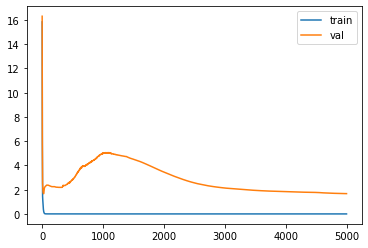

In [201]:
#Train versus val errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
    
plt.plot(load_dict['train_losses'], label='train')
plt.plot(load_dict['val_losses'], label="val")

plt.legend()

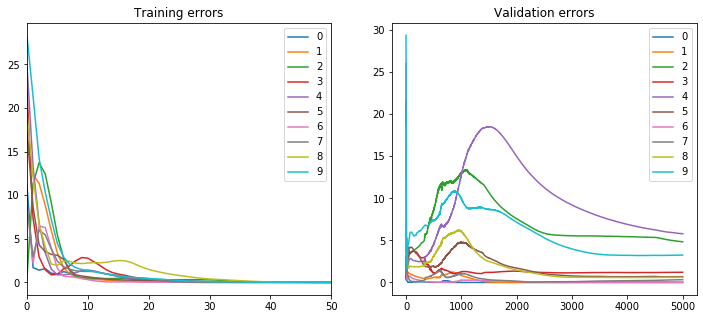

In [202]:
# Visualize per-number errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

fig, ax = plt.subplots(1, 2,  figsize=(12, 5))

for number, losses in enumerate(load_dict['train_number_losses']):
    ax[0].set_title("Training errors")
    ax[0].plot(losses, label=str(number))
    ax[0].legend()
    ax[0].set_xlim(0, 50)

    
for number, losses in enumerate(load_dict['val_number_losses']):
    ax[1].set_title("Validation errors")
    ax[1].plot(losses, label=str(number))
    ax[1].legend()

plt.show()

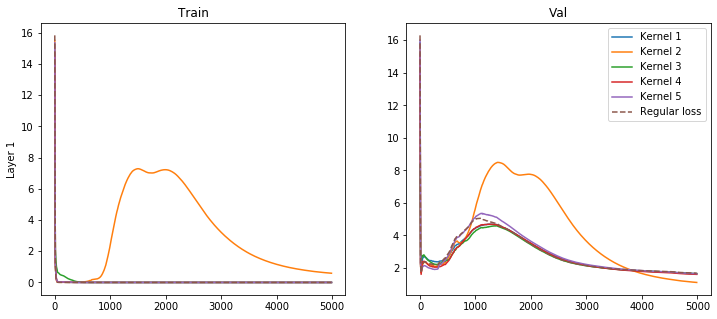

In [203]:
# Plot exclusion losses
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")

train_ex_losses = load_dict['train_ex_losses']
train_losses = load_dict['train_losses']
val_ex_losses = load_dict['val_ex_losses']
val_losses = load_dict['val_losses']

n_layers = len(train_ex_losses[0])
timesteps = np.arange(0, num_epochs, calc_ex_loss_every)

fig, ax = plt.subplots(n_layers, 2, figsize=(12, 5*n_layers))

for layer_idx in range(n_layers):
    layer_ax = ax[layer_idx] if n_layers > 1 else ax
    # Allocate memory 
    num_kernels = len(train_ex_losses[0][layer_idx])
    layer_losses = np.zeros((2, num_kernels, timesteps.size))

    # Gather data for each time step
    for t in range(timesteps.size):
        layer_losses[0, :, t] = train_ex_losses[t][layer_idx]
        layer_losses[1, :, t] = val_ex_losses[t][layer_idx]
        
    # For each kernel, plot its corresponding graph
    for i in range(num_kernels):
        layer_ax[0].plot(timesteps, layer_losses[0, i, :],  label=f"Kernel {i+1}")
        layer_ax[1].plot(timesteps, layer_losses[1, i, :],  label=f"Kernel {i+1}")
    
    layer_ax[0].plot(timesteps, train_losses[0:num_epochs:calc_ex_loss_every], linestyle='dashed', label='Regular loss')
    layer_ax[0].set_title("Train")
    
    layer_ax[1].plot(timesteps, val_losses[0:num_epochs:calc_ex_loss_every], linestyle='dashed', label='Regular loss')
    layer_ax[1].set_title("Val")
    
    layer_ax[1].legend()
    layer_ax[0].set_ylabel(f"Layer {layer_idx+1}")


0 0
1 500
2 1000
3 1500
4 2000
5 2500
6 3000
7 3500
8 4000
9 4500
10 5000


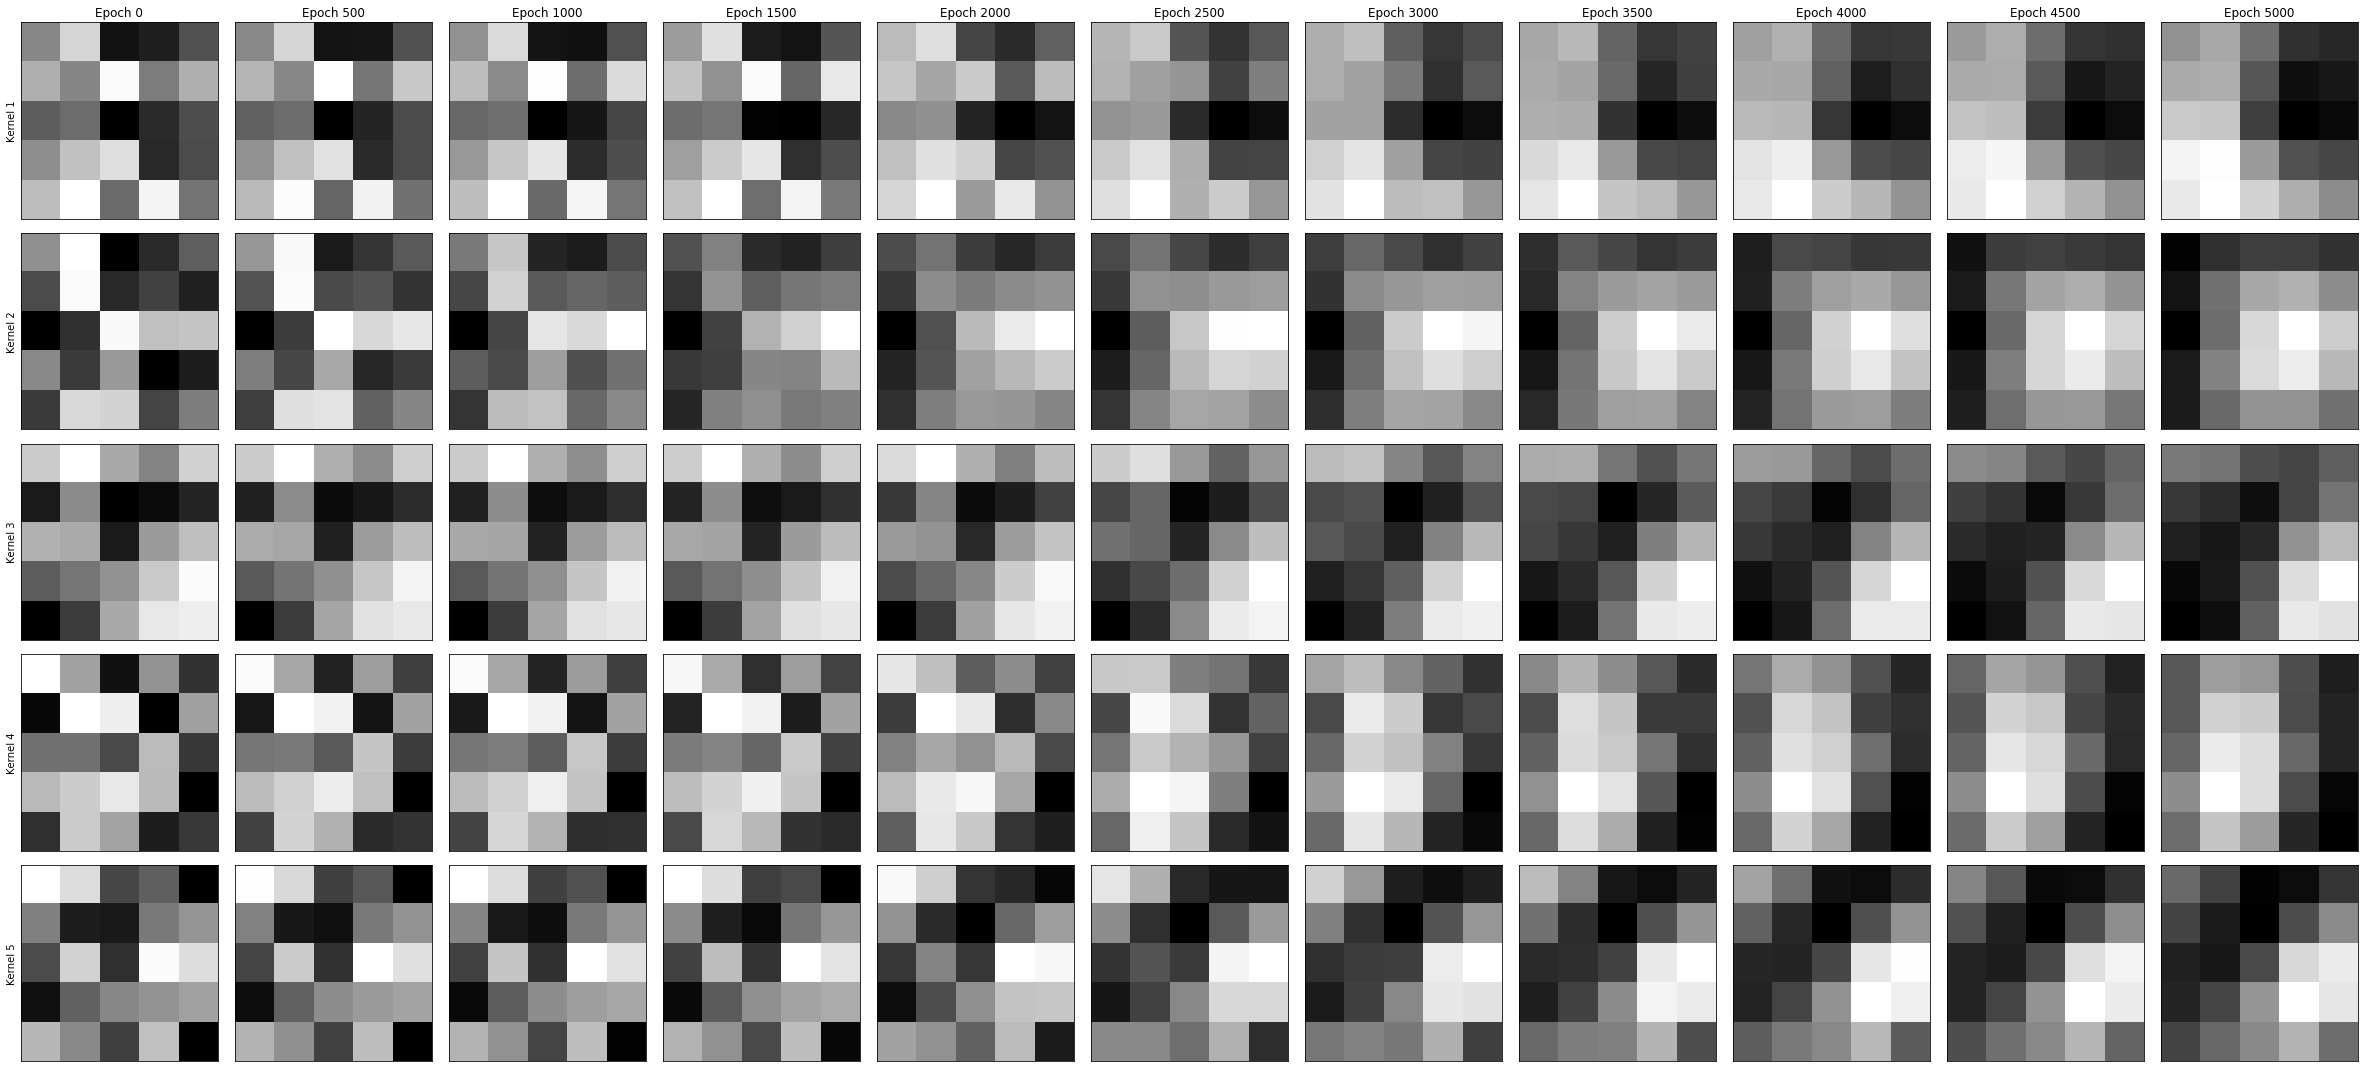

In [208]:
# Visualize kernels
def visualize_kernels(layer_num=1):
    cpts = glob.glob(f"checkpoints/{exp_name}/*")
    
    
    kernels = {}
    
    for cpt in cpts:
        if 'init' in cpt:
            continue
        elif 'final' in cpt:
            epoch = num_epochs
        else:
            epoch = int(os.path.basename(cpt).split(".")[0])
            
        load_dict = torch.load(cpt)
        
        kernels[epoch] = load_dict['model'][f'conv_seq.{layer_num-1}.weight']
        

    n_cols = len(list(kernels.items()))
    n_rows = len(list(kernels.items())[0][1])
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    
    for i, epoch in enumerate(sorted(kernels)):
        print(i, epoch)
        
        for j, kernel in enumerate(kernels[epoch].squeeze()):
            ax = axs[j][i] 

            # Layout
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(kernel.cpu(), cmap='gray')
        
            if i == 0:
                ax.set_ylabel(f"Kernel {j+1}")
            if j == 0:
                ax.set_title(f"Epoch {epoch}")
    plt.tight_layout()
        
visualize_kernels()